# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

from sklearn.preprocessing import StandardScaler

Load feature names.

In [2]:
feature_names = []
with open('./Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print ('Loaded feature names:{}'.format(len(feature_names)))

Loaded feature names:126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('./Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print ("{} {}".format(train_data.shape, test_data.shape))

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

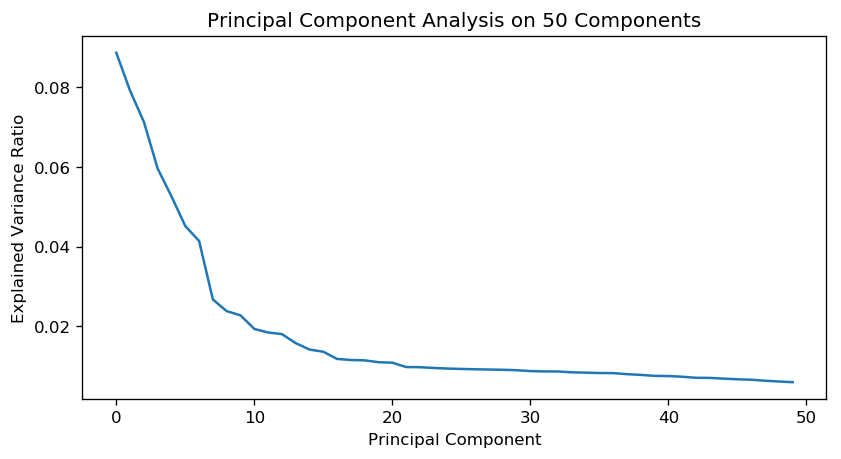

In [4]:
def P1():
### STUDENT START ###
    X = train_data
    
    k = 50
    
    X_norm = StandardScaler().fit_transform(X)
    
    pca = PCA(n_components=k)
    pca.fit(X_norm)
    fig = plt.figure(figsize=(8, 4), dpi=120)

    plt.plot(pca.explained_variance_ratio_)
    plt.title('Principal Component Analysis on 50 Components')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    
### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

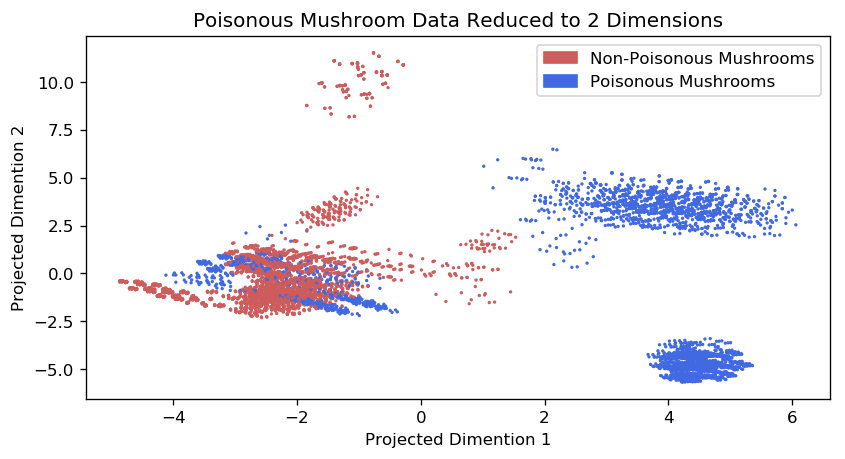

In [5]:
def P2():
### STUDENT START ###
    X = train_data
    y = train_labels
    
    X_norm = StandardScaler().fit_transform(X)
    
    k = 2
    pca = PCA(n_components=k)
    pca.fit(X_norm)
    
    X_proj = pca.transform(X_norm)
    kcolors = ['royalblue' if poisonous else 'indianred' for poisonous in y]
    
    fig = plt.figure(figsize=(8, 4), dpi=120)
    plt.scatter(X_proj[:,0], X_proj[:,1], s=1, color=kcolors)
    plt.title("Poisonous Mushroom Data Reduced to 2 Dimensions")
    plt.xlabel('Projected Dimention 1')
    plt.ylabel('Projected Dimention 2')
    import matplotlib.patches as mpatches
    poison_patch = mpatches.Patch(color='indianred', label='Non-Poisonous Mushrooms')
    nonpoison_patch = mpatches.Patch(color='royalblue', label='Poisonous Mushrooms')
    plt.legend(handles=[poison_patch, nonpoison_patch])
### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

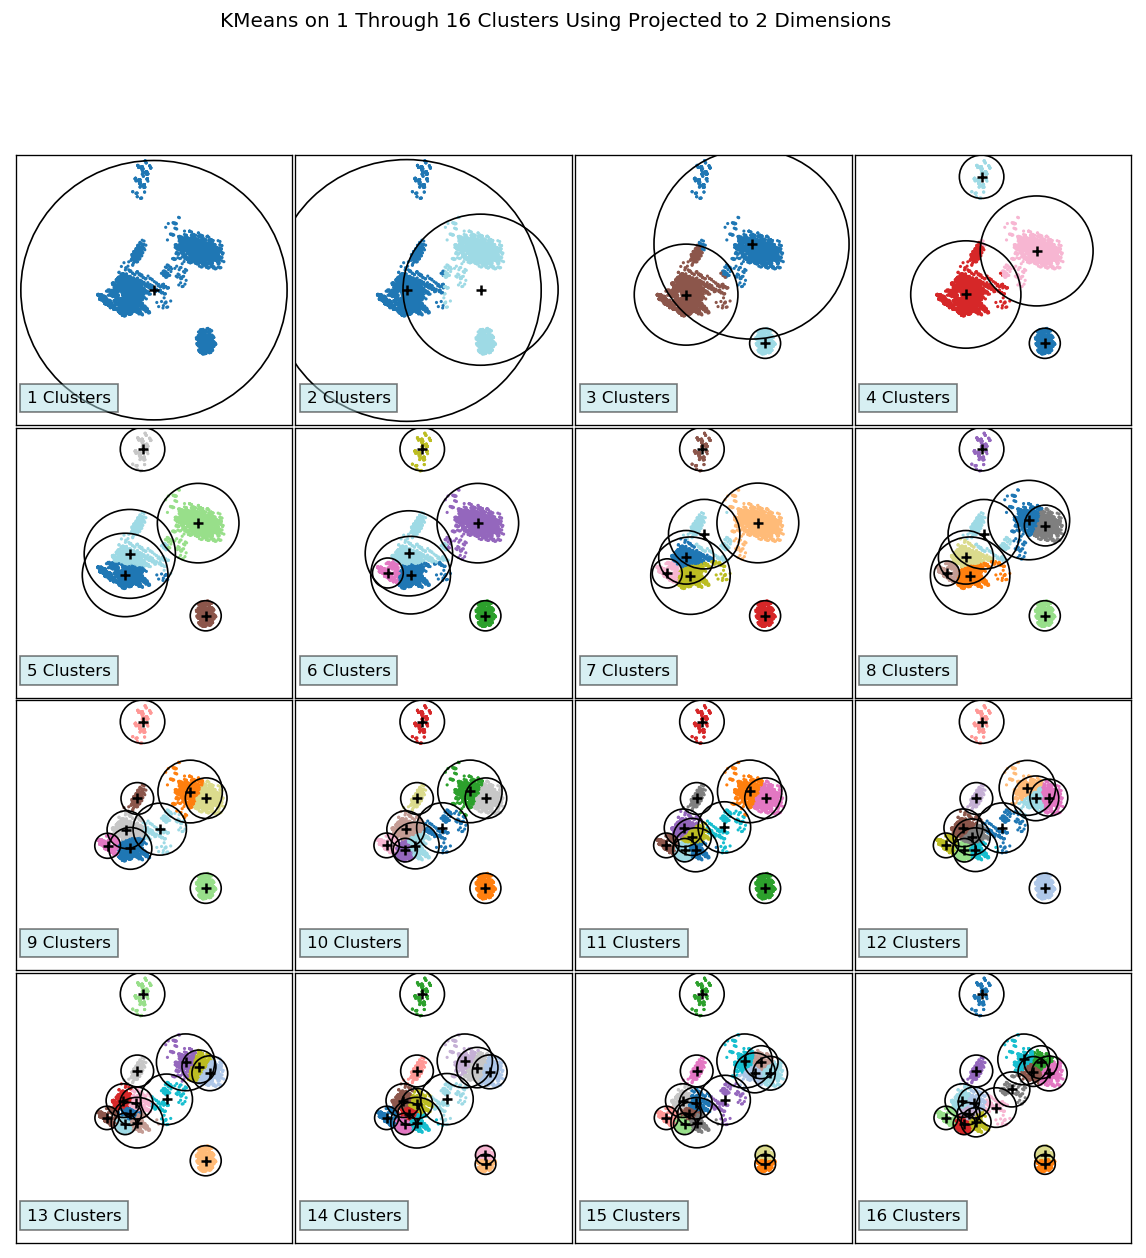

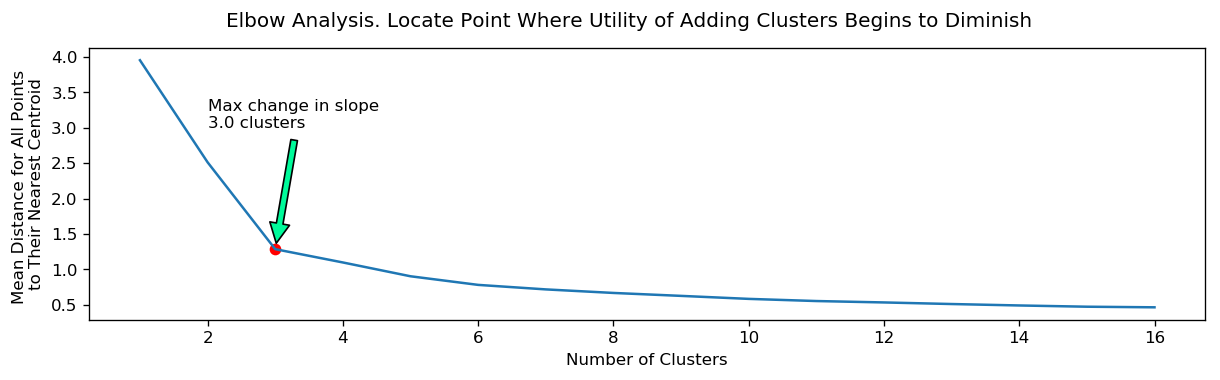

In [6]:
def P3():
### STUDENT START ###
    
    def plot_cluster(k, X, ax):
        kmeans = KMeans(n_clusters=k)
        y_pred = kmeans.fit_predict(X)
        
        # Create the main plot over k clusters
        ax.scatter(X[:, 0], X[:, 1], s=.8, c=y_pred, cmap='tab20')
        ax.set_xlim(-12,12)
        ax.set_ylim(-12,12)
        ax.set_xticks([])
        ax.set_yticks([])

        # Add centroids
        ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                    c='black', marker='+')

        # Get max distance per cluster and plot circle
        X_dist = kmeans.transform(X)
        total_distance = 0
        for i in range(k):
            tmp_values = X_dist[y_pred == i][:,i]
            tmp_max = np.max(tmp_values)
            max_circle = plt.Circle(kmeans.cluster_centers_[i], 
                                radius=tmp_max, fill=False, color='black')
            ax.add_artist(max_circle)
            
            total_distance += np.sum(tmp_values)
        # Caclulate mean distance
        mean_distance = total_distance/len(X_dist)
            
        # Add an title inside the plot
        ax.text(-11, -10,"{} Clusters".format(k), bbox=dict(facecolor='powderblue', alpha=0.5))
        
        return mean_distance
    
    X = train_data
    y = train_labels
    
    # Create projection
    X_norm = StandardScaler().fit_transform(X)
    k = 2
    pca = PCA(n_components=k)
    pca.fit(X_norm)
    X_proj = pca.transform(X_norm)
    
    # Create 4x4 figure of 16 different plots
    fig = plt.figure(figsize=(12, 12), dpi=120)
    fig.suptitle('KMeans on 1 Through 16 Clusters Using Projected to 2 Dimensions')
    
    mean_distances = []
    
    for i in range(1, 17):
        ax = fig.add_subplot(4,4,i)
        mean_distance = plot_cluster(i, X_proj, ax)
        mean_distances.append([i, mean_distance])
    
    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    
    
    ## Elbow Analysis
    # Calculate changes in slope
    slopes = [0] # Initialized with 0 since we need to skip the first
    slope_changes = [0,0]
    for i in range(1, len(mean_distances)):
        clusters, mean_distance = mean_distances[i]
        previous_mean_distance = mean_distances[i-1][1]
        slope = np.sqrt(mean_distance**2 + previous_mean_distance**2)
        slopes.append(slope)
        
        if i >= 2:
            slope_changes.append(slopes[i-1]-slopes[i])
            
    slope_changes = np.array(slope_changes)
    mean_distances = np.array(mean_distances)
    
    max_slope_change_index = np.argmax(slope_changes)
    
    fig2 = plt.figure(figsize=(12, 3), dpi=120)
    fig2.suptitle('Elbow Analysis. Locate Point Where Utility of Adding Clusters Begins to Diminish')
    ax2 = fig2.add_subplot(1,1,1)
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Mean Distance for All Points \nto Their Nearest Centroid')
    ax2.plot(mean_distances[:,0], mean_distances[:,1])
    ax2.scatter(mean_distances[max_slope_change_index,0], mean_distances[max_slope_change_index,1], 
                    c='red', marker='o')
    ax2.annotate('Max change in slope \n{} clusters'.format(mean_distances[max_slope_change_index,0]), 
            xy=(mean_distances[max_slope_change_index,0], mean_distances[max_slope_change_index,1]), 
            xytext=(2,3),
        arrowprops=dict(facecolor='mediumspringgreen', shrink=0.05),
    )

### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

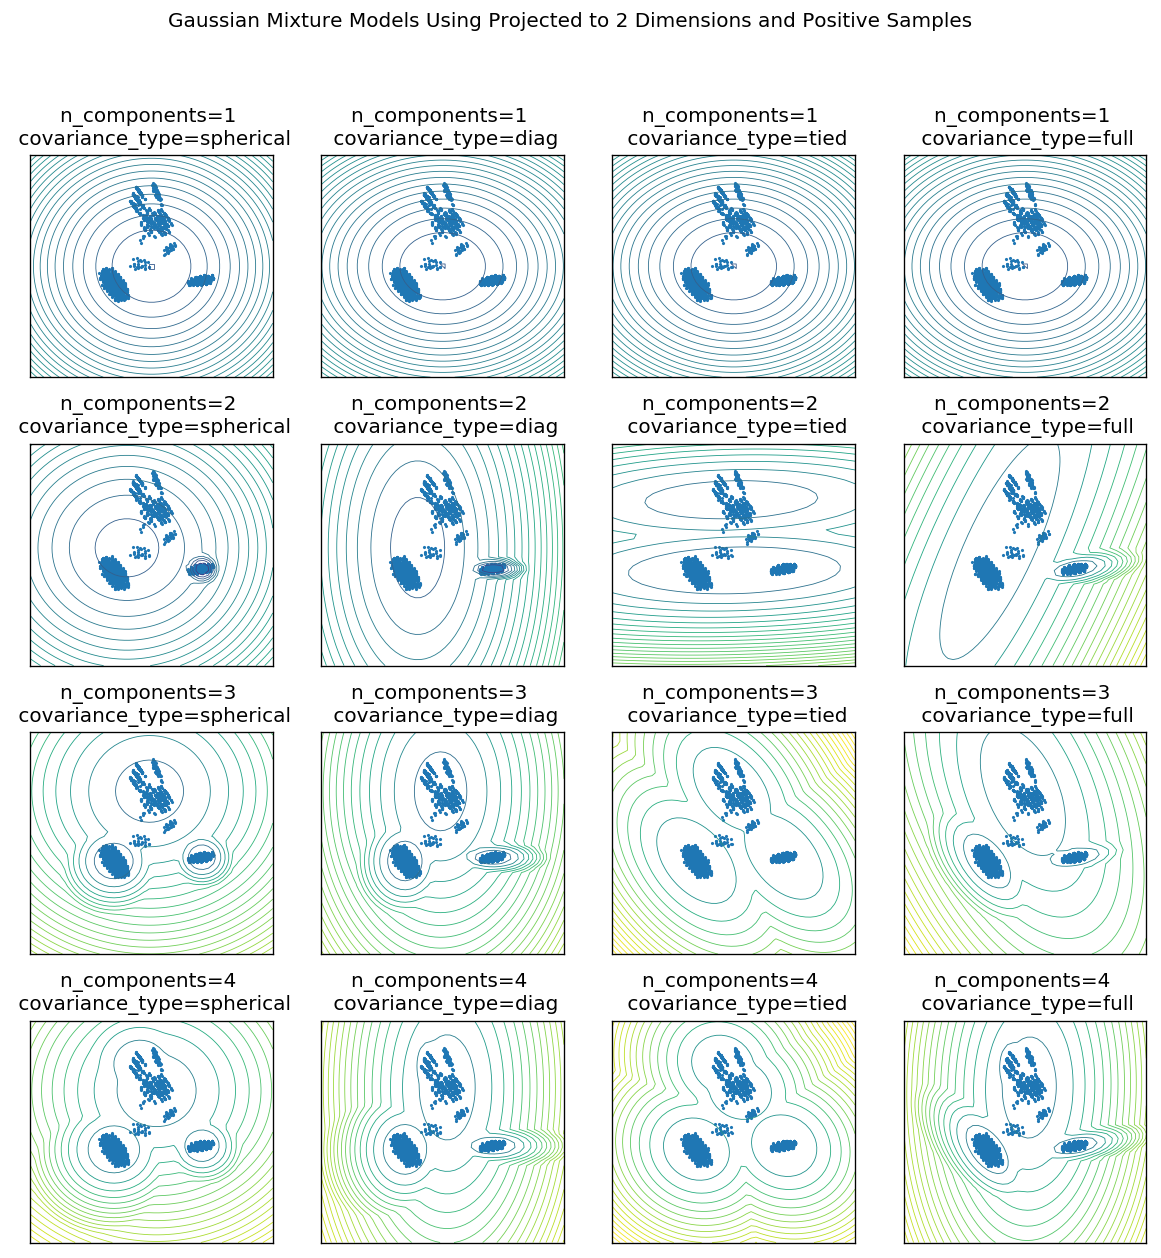

In [7]:
def P4():
### STUDENT START ###

    def plot_contour(clf, ax):
        # display predicted scores by the model as a contour plot
        x = np.linspace(-12, 12)
        y = np.linspace(-12, 12)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -clf.score_samples(XX)
        Z = Z.reshape(X.shape)
        L = np.linspace(np.min(Z), np.max(Z), 20)

        ax.contour(X, Y, Z, 
                   norm=LogNorm(vmin=1.0, vmax=200.0), 
                   levels=L,
                   linewidths=0.5)
        return
    

    X = train_data[train_labels==1]
    X_norm = StandardScaler().fit_transform(X)
    
    k = 2
    pca = PCA(n_components=k)
    pca.fit(X_norm)
    
    X_proj = pca.transform(X_norm)
    
    mixture_components = [1,2,3,4]
    mixture_types = ['spherical', 'diag', 'tied', 'full']
    
    fig = plt.figure(figsize=(12, 12), dpi=120)
    fig.suptitle('Gaussian Mixture Models Using Projected to 2 Dimensions and Positive Samples')
    
    fig_idx = 0
    
    for mix_comp in mixture_components:
        for mix_type in mixture_types:
            clf = GaussianMixture(n_components=mix_comp, covariance_type=mix_type)
            clf.fit(X_proj)
            
            fig_idx += 1
            ax = fig.add_subplot(4,4,fig_idx)
            ax.set_xlim(-12,12)
            ax.set_ylim(-12,12)
            ax.set_xticks([])
            ax.set_yticks([])


            plot_contour(clf, ax)
            ax.scatter(X_proj[:, 0], X_proj[:, 1], .8)
            ax.set_title('n_components={} \n covariance_type={}'.format(mix_comp, mix_type))
    
    fig.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.show()
### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
def P5():
### STUDENT START ###
    np.random.seed(111)
    
    mix_comp = 4
    mix_type='full'

    X = StandardScaler().fit_transform(train_data)
    y = train_labels
    
    X_test = StandardScaler().fit_transform(test_data)
    y_test = test_labels

    # Create 2 dimentional projection
    pca_2d = PCA(n_components=2)
    pca_2d.fit(X)

    X_test_2d = pca_2d.transform(X_test)

    
    # Possitive Model
    X_pos = X[y==1]
    X_pos_2d = pca_2d.transform(X_pos)
    clf_pos = GaussianMixture(n_components=mix_comp, covariance_type=mix_type).fit(X_pos_2d)
    prob_y_pos = clf_pos.score_samples(X_test_2d)
    
            
    # Negative Model
    X_neg = X[y==0]
    X_neg_2d = pca_2d.transform(X_neg)
    clf_neg = GaussianMixture(n_components=mix_comp, covariance_type=mix_type).fit(X_neg_2d)
    prob_y_neg = clf_neg.score_samples(X_test_2d)
    
    # Combine and score
    y_pred = prob_y_pos > prob_y_neg
    score = metrics.accuracy_score(y_test, y_pred)
    
    print("The score for the combined GMM's is {:0.3f}".format(score))
    
### STUDENT END ###

P5()

The score for the combined GMM's is 0.873


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [9]:
def P6():
### STUDENT START ###
    np.random.seed(11)
#     np.random.seed(2)

    def get_parameter_count(dimensions, components, component_mix):
        if component_mix == 'spherical':
            return int(2 * ((components * dimensions) + components * 1))
        elif component_mix == 'diag':
            return int(2 * ((components * dimensions) + components * dimensions))
        elif component_mix == 'full':
            return int(2 * ((components * dimensions) + components * 
                            ((dimensions * dimensions - dimensions) / 2 + dimensions)))
        elif component_mix == 'tied':
            return int(2 * ((components * dimensions) + 1 * 
                            ((dimensions * dimensions - dimensions) / 2 + dimensions)))
        
    X = StandardScaler().fit_transform(train_data)
    y = train_labels
    
    X_test = StandardScaler().fit_transform(test_data)
    y_test = test_labels

    max_parameters = 50
    classes = 2
    mixture_types = ['spherical', 'diag', 'tied', 'full']
    
    params = []
    scores = []
    covariances = []
    parameters = []
    
    for dimension in range(1,max_parameters+1):
        # Create the PCA with this iter's dimension
        pca_nd = PCA(n_components=dimension)
        pca_nd.fit(X)
        X_test_nd = pca_nd.transform(X_test)
        
        X_pos = X[y==1]
        X_pos_nd = pca_nd.transform(X_pos)

        X_neg = X[y==0]
        X_neg_nd = pca_nd.transform(X_neg)
        
        for mix_type in mixture_types:
            for component in range(1, int(max_parameters/classes)+1):

                # If we're exceeding the max_parameters, break this loop.
                parameter_count = get_parameter_count(dimension, component, mix_type)
                if parameter_count > max_parameters:
                    break

                # Possitive Model
                clf_pos = GaussianMixture(n_components=component, covariance_type=mix_type).fit(X_pos_nd)
                prob_y_pos = clf_pos.score_samples(X_test_nd)

                # Negative Model
                clf_neg = GaussianMixture(n_components=component, covariance_type=mix_type).fit(X_neg_nd)
                prob_y_neg = clf_neg.score_samples(X_test_nd)

                # Combine and score
                y_pred = prob_y_pos > prob_y_neg
                score = metrics.accuracy_score(y_test, y_pred)

                params.append([dimension, component])
                scores.append(score)
                covariances.append(mix_type)
                parameters.append(parameter_count)

    params = np.array(params)
    scores = np.array(scores)
    covariance_types = np.array(covariances)
    parameter_counts = np.array(parameters)
    return params, scores, covariance_types, parameter_counts
    
    

### STUDENT END ###

params, scores, covariance_types, parameter_counts = P6()

Peforming 164 tests without using a total 40 parameters, the max score acheived is 0.955.
The hyperparameters for this were: PCA.n_components=9, GMM.n_components=2 and covariance_type=spherical


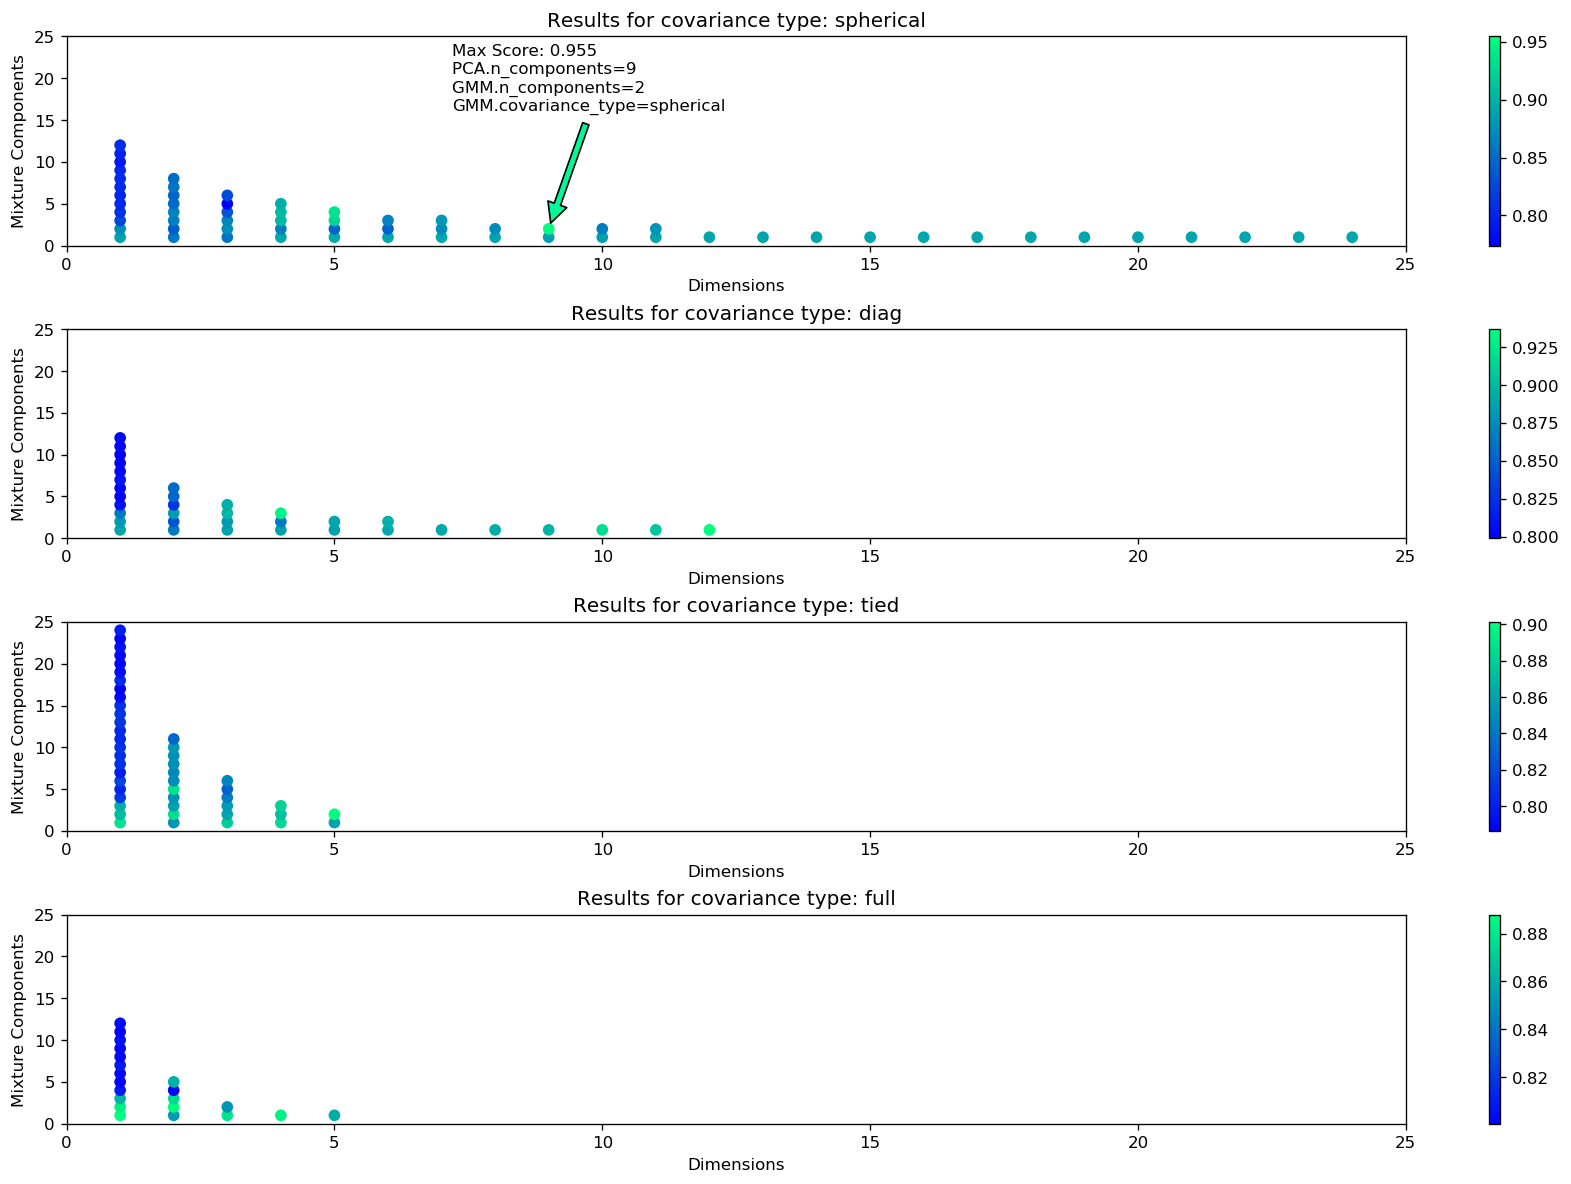

In [10]:
def P6_2():
    mixture_types = ['spherical', 'diag', 'tied', 'full']
    max_score_index = np.argmax(scores)
    max_score = scores[max_score_index]
    iter_num = len(scores)
    max_score_parameter_count = parameter_counts[max_score_index]

    max_index = params[max_score_index]
    max_mix_type = covariance_types[max_score_index]

    print("Peforming {} tests without using a total {} parameters, the max score acheived is {:0.3f}."
          .format(iter_num, max_score_parameter_count, max_score))
    print("The hyperparameters for this were: PCA.n_components={}, GMM.n_components={} and covariance_type={}"
          .format(max_index[0], max_index[1], max_mix_type))


    fig = plt.figure(figsize=(18,12), dpi=120)
    for i in range(4):
        ax = fig.add_subplot(4,1,i+1)
        sub_params = params[covariance_types == mixture_types[i]]
        sub_scores = scores[covariance_types == mixture_types[i]]
        im = ax.scatter(sub_params[:,0], sub_params[:,1], c=sub_scores, cmap='winter')
        ax.set_title("Results for covariance type: {}".format(mixture_types[i]))
        ax.set_xlim(0,25)
        ax.set_ylim(0,25)
        ax.set_xlabel('Dimensions')
        ax.set_ylabel('Mixture Components')


        if max_score in sub_scores:
            ax.annotate('Max Score: {:0.3f} \nPCA.n_components={} \nGMM.n_components={} \nGMM.covariance_type={}'
                        .format(max_score, max_index[0], max_index[1], max_mix_type), 
                        xy=max_index, xytext=(0.8,8)*max_index,
                arrowprops=dict(facecolor='mediumspringgreen', shrink=0.05),
            )
        fig.colorbar(im)  

    fig.subplots_adjust(wspace=0, hspace=0.4)
    

P6_2()